In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DATALOADERS AND VISUALISING INPUT DATA**

In [ ]:
# DATA AUGMENTATIONS
data_transforms = {
    'train': transforms.Compose([                   #Normalization for training
        transforms.Resize((256, 256)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([                     #Normalization for validation
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Accessing dataset from Google Drive. Training data in 'train'. Validation data in 'val'
data_dir = '/content/drive/MyDrive/trainer_model'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

['Reactive hyperplasia', 'Normal Lymphnode', 'Normal Lymphnode', 'Reactive hyperplasia', 'Normal Lymphnode', 'Reactive hyperplasia', 'Reactive hyperplasia', 'Normal Lymphnode', 'Reactive hyperplasia', 'Normal Lymphnode', 'Reactive hyperplasia', 'Normal Lymphnode', 'Normal Lymphnode', 'Normal Lymphnode', 'Normal Lymphnode', 'Normal Lymphnode', 'Reactive hyperplasia', 'Normal Lymphnode', 'Normal Lymphnode']


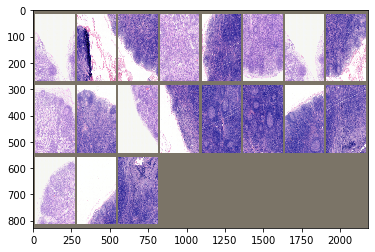

In [ ]:
#Function for visualizing a grid from a batch of training data.
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)              # limits the values in an array between 0 and 1
    plt.imshow(inp, interpolation='nearest', aspect='auto')
    plt.pause(0.001)                      # pause a bit so all plots are updated


# Get a batch of training data for visualizaiton
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch of training data.
out = torchvision.utils.make_grid(inputs, padding=15)

title1=[class_names[x] for x in classes]
print(title1)
imshow(out, title=None)

# **FUNCTION TO TRAIN MODEL**

In [ ]:
train_loss = list()
train_acc = list()

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())              
    best_acc = 0.0
    best_acc1 = 0.0
    
    # val_loss = list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            count = 1

            # Iterate over data. Inputs and labels to GPU
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward propogation
                # track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward to calculate error
                    # optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # train_loss.append(running_loss)
            if phase == 'train':
                scheduler.step()            #as we move down towards GD we want to slow down lr
            #Calculating loss and accuracy at each epoch
            epoch_loss = running_loss / dataset_sizes[phase]            
            epoch_acc = running_corrects.double() / dataset_sizes[phase]   
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
  
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train' and epoch_acc > best_acc1:
                best_acc1 = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best train Acc: {:4f}'.format(best_acc1))      #Best Validation Accuracy & Training Accuracy achieved over num_epochs epochs
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# **FUNCTION TO DISPLAY PREDICTIONS**

In [ ]:
#Function for displaying model predictions. Displaying 7 validation image predictions.
def visualize_model(model, num_images=7):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()  

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)    #inputs to GPU
            labels = labels.to(device)    #labels to GPU

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

             #Display predicted class v/s actual labels
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 7, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {}'.format(class_names[preds[j]]) + ' | ' + 'Actual: {}'.format(class_names[labels[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Pre-trained ResNet 50 Model**

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)   #ResNet 50 layer pre-trained model
for param in model_conv.parameters():
    param.requires_grad = False         

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)    #2 output classes (Normal & Reactive)
model_conv = model_conv.to(device)   

criterion = nn.CrossEntropyLoss()    # Cross entropy loss function
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)         # Adam Optimizer
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)   # Decay Learning Rate by a factor of 0.1 every 7 epochs

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **TRAINING**

In [ ]:
num_epochs = 15
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs)

Epoch 0/14
----------
train Loss: 2.1053 Acc: 0.0000
val Loss: 1.2144 Acc: 0.8571

Epoch 1/14
----------
train Loss: 1.1043 Acc: 0.4737
val Loss: 0.8559 Acc: 0.7143

Epoch 2/14
----------
train Loss: 0.7435 Acc: 0.6842
val Loss: 0.7226 Acc: 0.5714

Epoch 3/14
----------
train Loss: 0.6189 Acc: 0.6316
val Loss: 0.6639 Acc: 0.5714

Epoch 4/14
----------
train Loss: 0.5553 Acc: 0.6316
val Loss: 0.6186 Acc: 0.7143

Epoch 5/14
----------
train Loss: 0.4912 Acc: 0.6316
val Loss: 0.5835 Acc: 0.7143

Epoch 6/14
----------
train Loss: 0.4232 Acc: 0.7368
val Loss: 0.5649 Acc: 0.8571

Epoch 7/14
----------
train Loss: 0.3653 Acc: 1.0000
val Loss: 0.5600 Acc: 0.8571

Epoch 8/14
----------
train Loss: 0.3603 Acc: 1.0000
val Loss: 0.5541 Acc: 0.8571

Epoch 9/14
----------
train Loss: 0.3553 Acc: 1.0000
val Loss: 0.5492 Acc: 0.8571

Epoch 10/14
----------
train Loss: 0.3504 Acc: 1.0000
val Loss: 0.5449 Acc: 1.0000

Epoch 11/14
----------
train Loss: 0.3454 Acc: 1.0000
val Loss: 0.5389 Acc: 1.0000

Ep

# **PREDICTIONS**

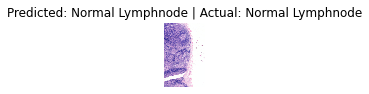

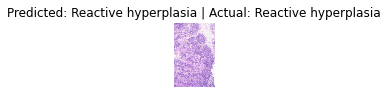

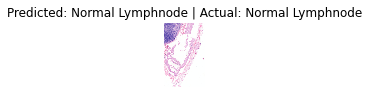

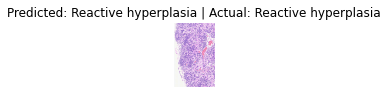

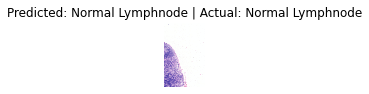

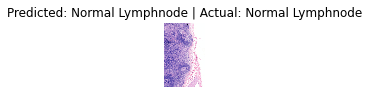

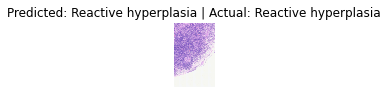

In [ ]:
visualize_model(model_conv)
#Displaying the 7 model predictions
plt.ioff()
plt.show()

# **PLOTS**

In [ ]:
j=0
total_val_loss = list()
while (j<=(num_epochs*2)):
  if j%2!=0:
    total_val_loss.append(train_loss[j])
  j+=1
# total_val_loss

a=0
total_val_acc = list()
while (a<=(num_epochs*2)):
  if a%2!=0:
    total_val_acc.append(train_acc[a].detach().cpu().numpy())
  a+=1
# total_val_acc

b=0
total_train_acc = list()
while (b<=((num_epochs*2)-1)):
  if b%2==0:
    total_train_acc.append(train_acc[b].detach().cpu().numpy())
  b+=1
# total_train_acc

i=1
total_train_loss = list()
total_train_loss.append(train_loss[0])
while (i<=((num_epochs*2)-1)):
  if i%2==0:
    total_train_loss.append(train_loss[i])
  i+=1
# total_train_loss

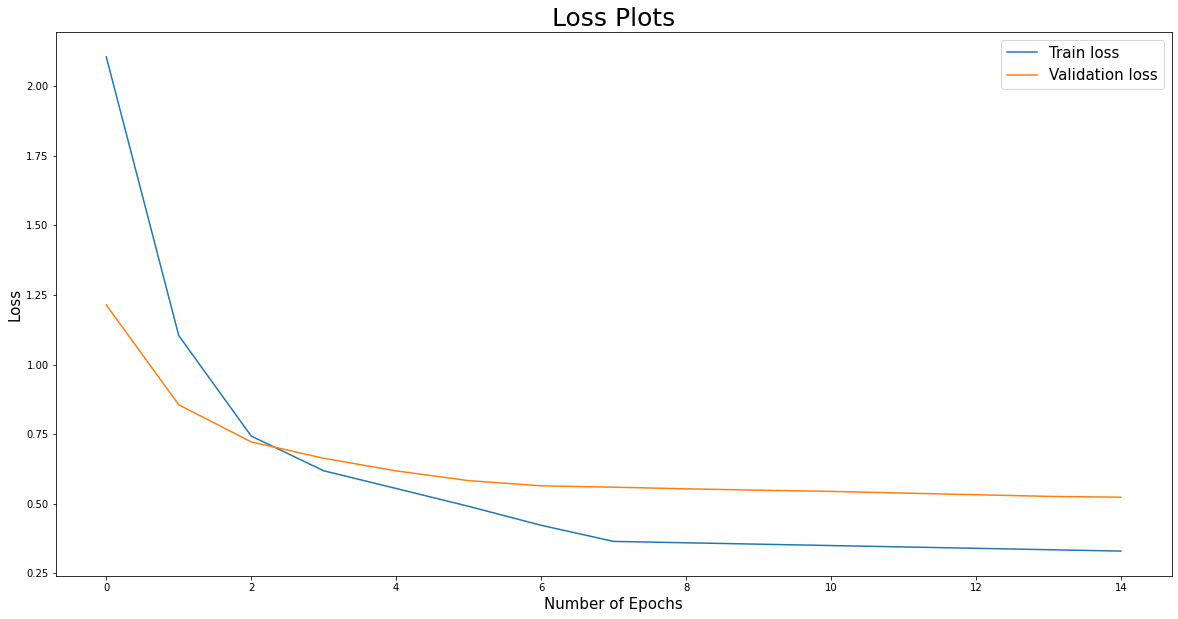

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(0, num_epochs), total_train_loss, label="Train loss")
plt.plot(np.arange(0, num_epochs), total_val_loss, label="Validation loss")
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Number of Epochs', fontsize=15)
plt.title("Loss Plots", fontsize=25)
plt.legend(loc='best',prop={"size":15})
plt.show()

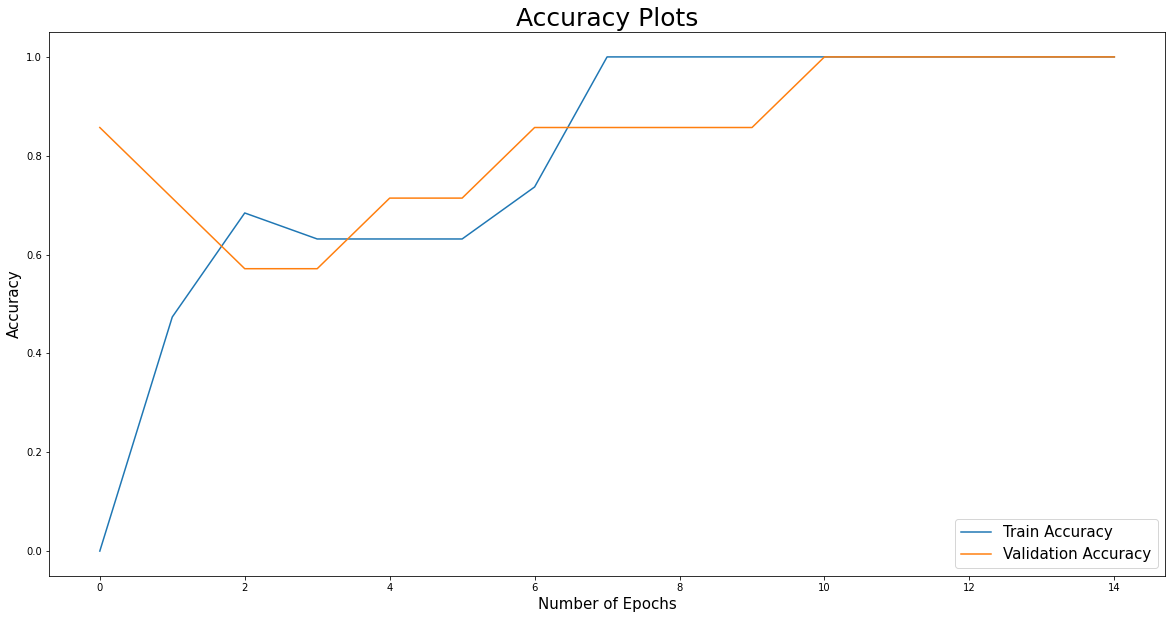

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(0, num_epochs), total_train_acc, label="Train Accuracy")
plt.plot(np.arange(0, num_epochs), total_val_acc, label="Validation Accuracy")
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Number of Epochs', fontsize=15)
plt.title("Accuracy Plots", fontsize=25)
plt.legend(loc=4,prop={"size":15})
plt.show()